##Aims and objectives:
Present the results obtained with ResNet18 on CIFAR10 10% and CIFAR10 total. 

Present also perf of ResNet18 on specific subset of CIFAR10


In [1]:
#imports and hyperparameters
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, models
import numpy as np

##Device and hyper parameters:


In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_epochs = 10

##CIFAR10

In [3]:
 # CIFAR-10 dataset

# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

cifar_train = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

cifar_test = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False, 
                                            transform=transforms.ToTensor())


Files already downloaded and verified


###Split by 10 %

In [4]:
def split_cifar(p): #p the percentage of cifar kept
  #take 10%
  data_percent=p
  len_train = int(len(cifar_train)*data_percent)
  len_test = int(len(cifar_test)*data_percent)
  train_dataset = torch.utils.data.Subset(cifar_train, np.arange(len_train))
  test_dataset = torch.utils.data.Subset(cifar_test, np.arange(len_test))
  return train_dataset, test_dataset

##Model: ResNet18 

In [5]:
def get_model():
  return models.resnet18(pretrained=False).to(device)

##Train function

In [6]:
#objective function

def func(params,p): 
  '''generates and train a ResNet18 model on CIFAR10. accuracy after 10 epochs'''

  learning_rate, batch_size = params
  learning_rate, batch_size = np.abs(learning_rate), int(np.abs(batch_size))

  print ("Current params : learning_rate:{:.4f}; batch_size:{}"
    .format(learning_rate, batch_size))

  #split cifar10
  train_dataset, test_dataset = split_cifar(p)

  # Data loader using batch size
  train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

  test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)


  #model
  model = get_model()

  #train the model
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

  total_step = len(train_loader)
  curr_lr = learning_rate
  for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.to(device)

      # Forward pass
      outputs = model(images)
      loss = criterion(outputs, labels)

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    scheduler.step()

  #test the model
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  
  #compute accuracy
  accuracy = correct / total

  print(f"lr :{learning_rate} Inverse accuracy:{accuracy}")
  print()

  return accuracy


##Plot results

On affiche les résultats obtenus pour 10% de CIFAR10 sur ResNet18 et pour 100% de CIFAR 10

In [7]:
#on evalue nos différents tests du ResNet18
%%time
'''
On teste pour Learning_rate=1e-3 et batch_size = 64

acc = 0.37 si reste à 1e-5 tout le temps sur 10%
'''

p_list = [0.1]

acc_perf = dict()

for p in p_list:
  acc = func([1e-3,64],p)
  acc_perf[f"CIFAR10_{100*p}%"] = [acc]

Current params : learning_rate:0.0010; batch_size:64


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


lr :0.001 Inverse accuracy:0.451

CPU times: user 10min 35s, sys: 1.09 s, total: 10min 36s
Wall time: 10min 44s


In [8]:

#from previous simulations
#Computed time 4h6min for all the training with ResNet18

acc_perf = { #accuracy for the different dataset with the same models
    "10%":[0.401],
    "20%" : [0.512],
    "30%":[0.580],
    "50%":[0.6604],
    "70%":[0.671],
    "100%":[0.7791],
}
print(acc_perf)


{'10%': [0.401], '20%': [0.512], '30%': [0.58], '50%': [0.6604], '70%': [0.671], '100%': [0.7791]}


In [9]:
#build dataframe with results
import numpy as np
import pandas as pd

df = pd.DataFrame(data=acc_perf)
df.head()

,10%,20%,30%,50%,70%,100%
0,0.401,0.512,0.58,0.6604,0.671,0.7791


##Plot results and display performance

Text(0, 0.5, 'Accuracy')

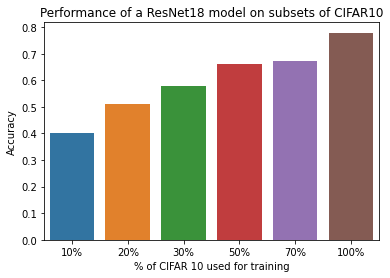

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(data = df).set(title ="Performance of a ResNet18 model on subsets of CIFAR10")
plt.xlabel("% of CIFAR 10 used for training")
plt.ylabel("Accuracy")